In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas
import json
import ot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import glob
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import random
import tqdm
from tqdm import tqdm
import seaborn as sb
import scipy as sp
import topo_util
from topo_util import noisy_disk, noisy_circle
import sklearn as sk
import sklearn.decomposition
import math
import pd

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


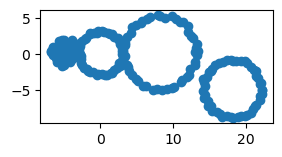

In [2]:
np.random.seed(42)
data1 = noisy_circle(50, 0.1, 0, 0, 3 )
data2 = noisy_circle(50, 0.1, 8, 0, 5)
data3 = noisy_circle(50, 0.1, 18, -5, 4 )
data4 = noisy_disk(50, 0.1, -5.1, 0, 2 )
A = np.concatenate([data4, data1, data2, data3])
plt.figure(figsize = (3, 3))
plt.scatter(A[:,0],A[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

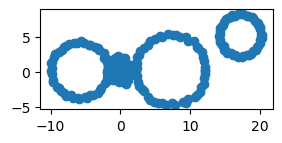

In [3]:
data1 = noisy_disk(50, 0.1, 0, 0, 2 )
data2 = noisy_circle(50, 0.1, 7, 0, 5 )
data3 = noisy_circle(50, 0.1, 17, 5, 3 )
data4 = noisy_circle(50, 0.1, -6, 0, 4 )
B = np.concatenate([data4, data1, data2, data3])
#B = np.concatenate([data1, data2, data4])
plt.figure(figsize = (3, 3))
plt.scatter(B[:,0],B[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [4]:
# C1 = sp.spatial.distance.cdist(A, A, "euclidean"); C1 /= np.mean(C1)
# C2 = sp.spatial.distance.cdist(B, B, "euclidean"); C2 /= np.mean(C2)
C_v0 = sp.spatial.distance.cdist(A, A, metric = "sqeuclidean"); C_v0 /= np.mean(C_v0)
C_v0 = np.exp(-C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "sqeuclidean"); C_v1 /= np.mean(C_v1)
C_v1 = np.exp(-C_v1)

In [5]:
p = ot.unif(len(A))
q = ot.unif(len(B))
gw0, log0 = ot.gromov.gromov_wasserstein(
    C_v0, C_v1, p, q, 'square_loss', verbose=True, log=True)
print('Gromov-Wasserstein distances: ' + str(log0['gw_dist']))
P = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
Id = [t[0] for t in A]
p = np.matmul(P, Id)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.227410e-01|0.000000e+00|0.000000e+00
    1|1.158206e-01|9.231558e-01|1.069204e-01
    2|5.673172e-02|1.041549e+00|5.908887e-02
    3|3.824755e-02|4.832772e-01|1.848417e-02
    4|2.943202e-02|2.995218e-01|8.815530e-03
    5|1.511979e-02|9.465888e-01|1.431223e-02
    6|9.174821e-03|6.479660e-01|5.944972e-03
    7|8.559748e-03|7.185641e-02|6.150728e-04
    8|7.665695e-03|1.166304e-01|8.940532e-04
    9|7.414033e-03|3.394398e-02|2.516618e-04
   10|7.413997e-03|4.956220e-06|3.674540e-08
   11|7.413997e-03|0.000000e+00|0.000000e+00
Gromov-Wasserstein distances: 0.007413996648262815


In [6]:
# Construct color scale for plotting
# Construct color scale for plotting
one = topo_util.get_eigvec(A[:50])
one = one - min(one)
one = (one/max(one))/4
two = topo_util.get_eigvec(A[50:100])
two = two - min(two)
two = 0.5 + (two/max(two))/4
three = 0.75 + np.zeros((50,))
four  = np.ones((50,))
color_figures = np.concatenate([one,two, three,four])

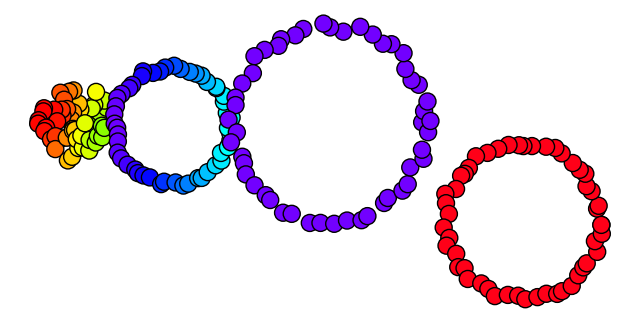

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(A[:,0],A[:,1],c = color_figures, s=150,edgecolors='black', vmax=1, vmin=0, cmap = "hsv")
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/ex2_source.svg')
plt.show()

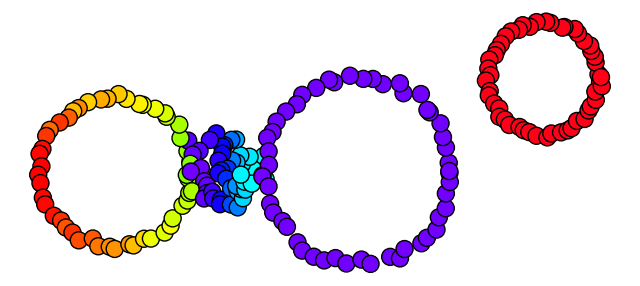

In [8]:
P_gromov = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
p_gromov = np.matmul(P_gromov, color_figures)

fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(B[:,0],B[:,1],c = p_gromov, s=150,edgecolors='black', vmax=1, vmin=0, cmap = "hsv")
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.savefig('../outputs/ex2_target_GW.svg')
plt.show()

In [9]:
def PH(X):
    df = pandas.DataFrame()
    for ii in range(X.shape[1]):
        df['x_{}'.format(ii)] =  X[:,ii]
    df.to_csv("pointcloud.tsv", sep = '\t', index = False)
    !julia ../src/PH.jl 
    with open('PH.json','r') as f:
        dic = json.load(f)
    return dic    

In [10]:
H_all = [PH(x) for x in tqdm([A,B])]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:22<00:00, 11.45s/it]


In [11]:
df1 = topo_util.make_dataframe(H_all[0]["barcode"])
df2 = topo_util.make_dataframe(H_all[1]["barcode"])

In [12]:
import ot
p_spt = df1.iloc[:, 0:2].to_numpy()
q_spt = df2.iloc[:, 0:2].to_numpy()
p, q = pd.augmented_weights(p_spt, q_spt)
C = pd.augmented_cost(p_spt, q_spt)

In [13]:
import matplotlib.pyplot as plt
import importlib
import numpy as np
from tqdm import tqdm
import hypernetx as hnx
import tpot

/home/syz/miniconda3/envs/tpot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [14]:
G_all = [hnx.Hypergraph({str(i) : k for (i, k) in enumerate(g['representatives'])}) for g in H_all]

In [15]:
y0, w0, v0 = topo_util.process_hg(G_all[0], A.shape[0])
y1, w1, v1 = topo_util.process_hg(G_all[1], B.shape[0])

In [16]:
# similarity with kernel
h = 0.25
K0 = topo_util.get_kernel(A, h)
L0 = topo_util.symmetric_laplacian(K0)
K0 /= K0.sum(-1).reshape(-1, 1)
K1 = topo_util.get_kernel(B, h)
L1 = topo_util.symmetric_laplacian(K1)
K1 /= K1.sum(-1).reshape(-1, 1)
y0_imputed = topo_util.impute_laplacian(y0, L0)
y1_imputed = topo_util.impute_laplacian(y1, L1)
y0 = y0_imputed; y1 = y1_imputed;

In [17]:
C_v0 = sp.spatial.distance.cdist(A, A, metric = "sqeuclidean"); C_v0 /= np.mean(C_v0)
C_v0 = np.exp(-C_v0)
C_v1 = sp.spatial.distance.cdist(B, B, metric = "sqeuclidean"); C_v1 /= np.mean(C_v1)
C_v1 = np.exp(-C_v1)
C_pd = pd.augmented_cost(p_spt, q_spt); C_pd /= C_pd[:-1, :-1].mean()

In [18]:
alpha = 0.8

v0 = p
v1 = q
pi_s, pi_f, _, = tpot.TPOT(y0, y1, w0, w1, v0, v1,
                           C_v0, C_v1, C_pd, 
                           alpha = alpha, beta = 5,  
                           print_iter = 5, iter = 100, numItermax = 1000, 
                           eps_s = 0.01, eps_f = 0.01,
                           solver = "sinkhorn", 
                          )

Iteration 0,	 obj = 0.1590158584066071,	 obj_terms = {'coot': 0.08967226187266353, 'ot': 0.0004890424598882178, 'gw': 0.06885455407405533}
Iteration 5,	 obj = 0.040958228267899535,	 obj_terms = {'coot': 0.0199471346257008, 'ot': 0.0033449172222190415, 'gw': 0.017666176419979692}
Iteration 10,	 obj = 0.03993973582455137,	 obj_terms = {'coot': 0.01892406002763795, 'ot': 0.003337544344489033, 'gw': 0.017678131452424386}
Iteration 15,	 obj = 0.03986668580758318,	 obj_terms = {'coot': 0.018851245779497913, 'ot': 0.003337216208707316, 'gw': 0.017678223819377947}
Iteration 20,	 obj = 0.039863261207187056,	 obj_terms = {'coot': 0.018847854628475484, 'ot': 0.00333718996550416, 'gw': 0.017678216613207415}
Iteration 25,	 obj = 0.039863114921861745,	 obj_terms = {'coot': 0.018847709258068477, 'ot': 0.0033371893813720424, 'gw': 0.01767821628242123}
is_converged, obj = 0.03986311046863467, obj_new = 0.03986311020120269


In [19]:
P = (pi_s / pi_s.sum(axis=-1)[:, np.newaxis])
Q = (pi_f[:-1, :-1] / pi_f[:-1, :-1].sum(axis=-1)[:, np.newaxis])
Q[np.isnan(Q)] = 0

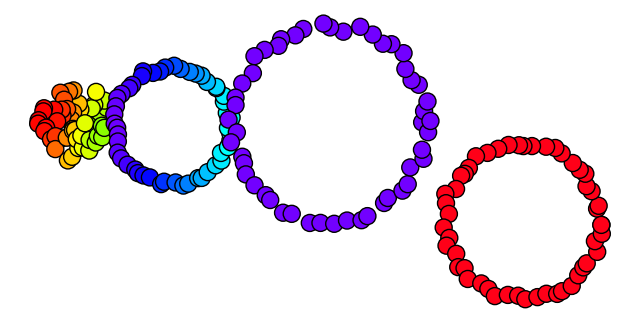

In [20]:
fig = plt.figure()
ax = fig.add_subplot()
scat = ax.scatter(A[:,0],A[:,1],c = color_figures, s=150,edgecolors='black', vmax=1, vmin=0, cmap = 'hsv')
plt.gca().set_aspect('equal')
ax.set_axis_off()
plt.show()

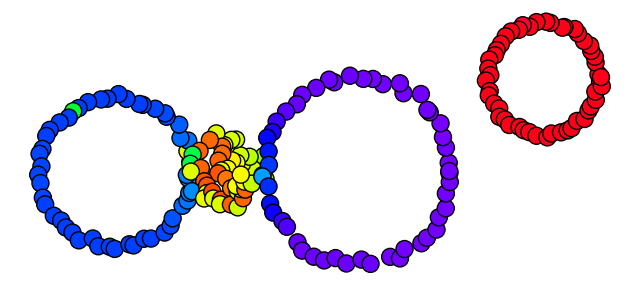

In [21]:
color_target  = np.matmul(P.T, color_figures)

fig = plt.figure()
ax = fig.add_subplot()
P_gromov = gw0.T / gw0.sum(axis=0)[:, np.newaxis]
p_gromov = np.matmul(P_gromov, color_figures)

plt.scatter(B[:,0],B[:,1],c = color_target,s=150,edgecolors='black', vmax=1, vmin=0, cmap = 'hsv')
plt.gca().set_aspect('equal', adjustable='box')
ax.set_axis_off()

plt.savefig('../outputs/ex2_target_tpot_{}.svg'.format(alpha))


plt.show()

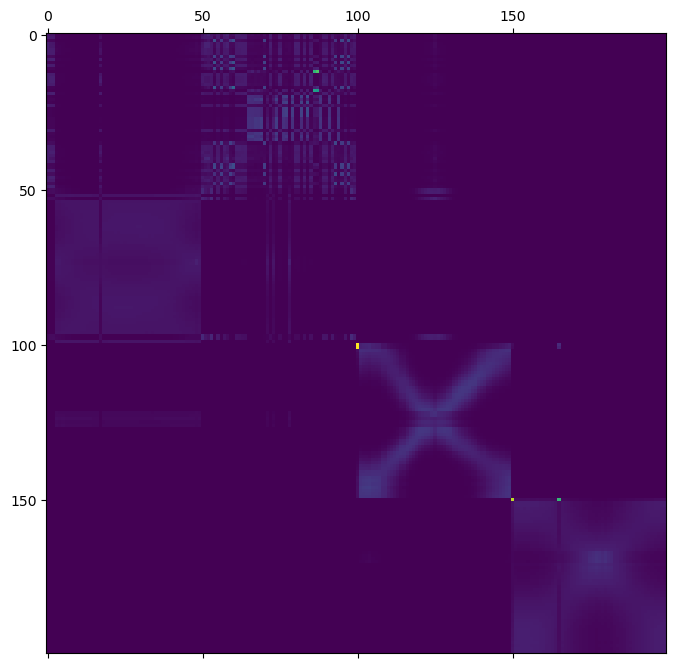

In [22]:
plt.matshow(P)

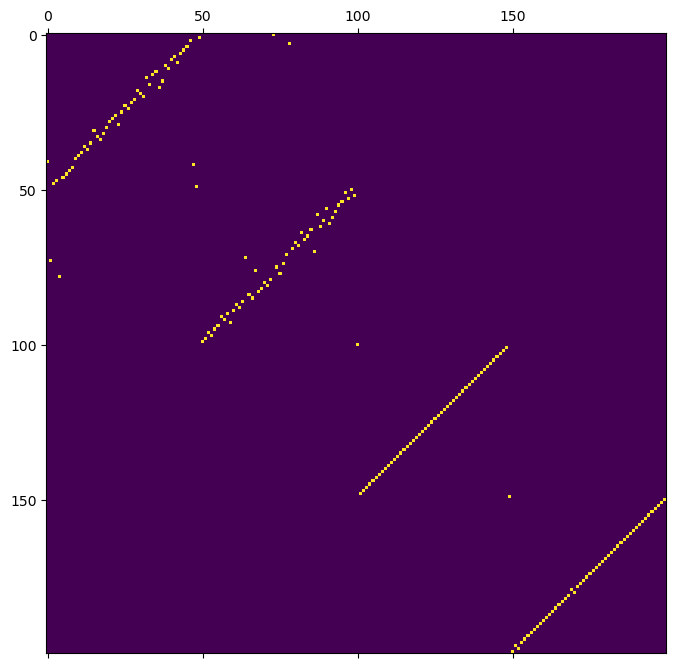

In [23]:
plt.matshow(P_gromov)

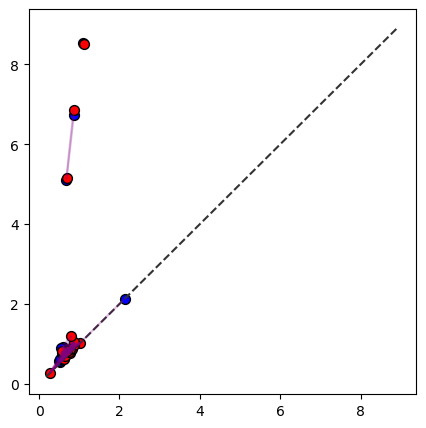

In [24]:
plt.figure(figsize = (5, 5))
pd.plot_pd_connections(p, q, p_spt, q_spt, pi_f)